In [1]:
# import libraries
import numpy as np
from torch.utils.data import DataLoader,TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import sys
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Reg-Data.txt to Reg-Data.txt


# Import and process the data

In [3]:
data = pd.read_csv('Reg-Data.txt', sep=',')
data.columns=np.arange(0,70,1)
data.head()
# z-score all columns (including quality!)
cols2zscore = data.keys()
#data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
data[cols2zscore] = data[cols2zscore]/np.max(data[cols2zscore])#.apply(stats.zscore)
cols2zscore
# convert from pandas dataframe to tensor

# but first drop residual sugar
cols2zscore = cols2zscore.drop([68,69])

dataT = torch.tensor( data[cols2zscore].values ).float()
xy = torch.tensor( data[[68,69]].values ).float()
#sugar = sugar[:,None] # transform to matrix


In [5]:
# use scikitlearn to split the data
#train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(dataT,xy)
#test_dataDataset  = TensorDataset(test_data,test_labels)


# train and test dataloaders
#test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=False, drop_last=True)

# Create the DL model

In [10]:
# create a class for the model
def createTheRadar(n_enc,n_bottle):

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(68,n_enc)
      
      ### encoder layer
      self.encoding = nn.Linear(n_enc,n_bottle)

      ### bottleneck layer
      self.bottleneck = nn.Linear(n_bottle,n_enc)

      ### decoder layer
      self.decoding = nn.Linear(n_enc,68)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.encoding(x) )
      x = F.relu( self.bottleneck(x) )
      y = torch.sigmoid( self.decoding(x) )
      return y
  
  # create the model instance
  net = aenet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

# Create a function that trains the model

In [11]:
def function2trainTheModel(n_enc,n_bottle):

  # number of epochs
  numepochs = 100
  
  # create a new model
  net,lossfun,optimizer = createTheRadar(n_enc,n_bottle)

  # initialize losses
  losses = []


  # batch size and number of batches
  #batchsize  = 32
  #numBatches = int(dataT.shape[0]/batchsize)


  # loop over epochs (now each epoch goes through all samples)
  for epochi in range(numepochs):

    
    # get a permuted index vector
    #randidx = np.random.permutation(dataT.shape[0]).astype(int)

    # losses during the batches
    batchlosses = []

    #for batchi in range(numBatches):
    for X,y in train_loader:
      
      # samples to use in this batch
      #samps2use = range((batchi-1)*batchsize,batchi*batchsize)
      

      # select those images
      #X = dataT[randidx[samps2use],:]

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    
      # losses in this batch
      batchlosses.append( loss.item() )
    # end minibatch loop
  
    losses.append(np.mean(batchlosses) )

  # function output
  return losses,net

In [21]:
np.arange(1,69,3)

array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49,
       52, 55, 58, 61, 64, 67])

# Run the experiment!

In [13]:
# specific the number of units
N_encdec_units = np.arange(10,300,30).astype(int)
N_bottle_units = np.arange(1,69,3).astype(int)


# initialize results matrix
exp_results = np.zeros((len(N_encdec_units),len(N_bottle_units)))


# start the experiment!
for ei,nenc in enumerate(N_encdec_units):
  for bi,nbot in enumerate(N_bottle_units):

    # build/train a model
    losses = function2trainTheModel(nenc,nbot)[0] # only need the first output
    exp_results[ei,bi] = np.mean(losses[-1])

    # send update message
    currentIter = ei*len(N_bottle_units)+bi+1
    totalIters  = len(N_bottle_units)*len(N_encdec_units)
    msg = 'Finished experiment {}/{}'.format(currentIter,totalIters)
    sys.stdout.write('\r' + msg)

Finished experiment 230/230

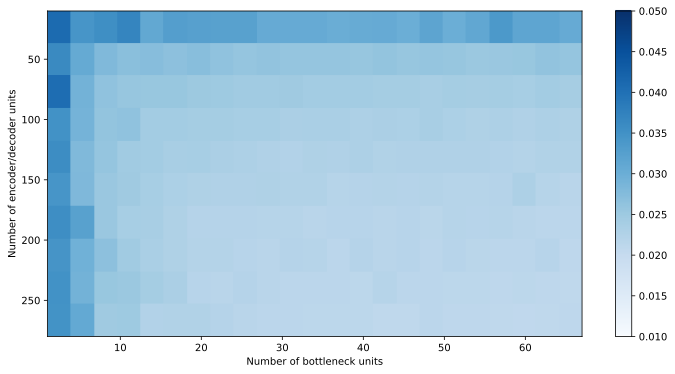

In [20]:
# show the results matrix
fig = plt.figure(figsize=(12,6))

plt.imshow(exp_results,aspect='auto',         # data and aspect ratio
           vmin=.01,vmax=.05, cmap='Blues', # color range and palette
           extent=[ N_bottle_units[0],N_bottle_units[-1],N_encdec_units[-1],N_encdec_units[0], ]) # xy axis ticks
           

plt.xlabel('Number of bottleneck units')
plt.ylabel('Number of encoder/decoder units')
plt.colorbar()

plt.show()